In [100]:
import torch
import pandas as pd
import numpy as np
from torch import nn
from torch.utils import data
from d2l import torch as d2l
from torchvision import datasets,transforms
import torchvision


class Reshape(torch.nn.Module):
    def forward(self,x):
        return x.view(-1,1,28,28)

net = torch.nn.Sequential(
    Reshape(),nn.Conv2d(1,6,kernel_size=5,padding=2),nn.Sigmoid(),
    nn.AvgPool2d(2,stride=2),
    nn.Conv2d(6,16,kernel_size=5),nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2,stride=2),nn.Flatten(),
    nn.Linear(16*5*5,120),nn.Sigmoid(),
    nn.Linear(120,84),nn.Sigmoid(),
    nn.Linear(84,10))
    

In [101]:
def get_dataloader_workers():  #@save
    """使用4个进程来读取数据"""
    return 4

In [102]:
def load_data_mnist(batch_size, resize=None):  #@save
    """下载MNIST数据集，然后将其加载到内存中"""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.MNIST(
        root="../data", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.MNIST(
        root="../data", train=False, transform=trans, download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=get_dataloader_workers()),
            data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=get_dataloader_workers()))

In [119]:
batch_size = 256
train_iter, test_iter = load_data_mnist(batch_size=batch_size)
print(type(test_iter))

test_data = pd.read_csv('test.csv')
print(test_data.iloc[1:4,[1,2,3,4,-1]])
test_data = np.array(test_data)

test_data = torch.tensor(test_data,dtype = torch.float32)


<class 'torch.utils.data.dataloader.DataLoader'>
   pixel1  pixel2  pixel3  pixel4  pixel783
1       0       0       0       0         0
2       0       0       0       0         0
3       0       0       0       0         0


In [ ]:
def evaluate_accuracy_gpu(net, data_iter, device=None): #@save
    """使用GPU计算模型在数据集上的精度"""
    if isinstance(net, nn.Module):
        net.eval()  # 设置为评估模式
        if not device:
            device = next(iter(net.parameters())).device
    # 正确预测的数量，总预测的数量
    metric = d2l.Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                # BERT微调所需的（之后将介绍）
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1] 

In [121]:
#@save
def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
    """用GPU训练模型(在第六章定义)"""
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # 训练损失之和，训练准确率之和，样本数
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')
    return y_hat

tensor([[-1.8365e+00,  1.1450e+00, -8.3428e+00,  2.8577e+00, -5.2802e+00,
          1.1267e+01, -1.3398e+00, -4.7679e+00,  4.1498e+00,  3.1230e+00],
        [-7.6379e+00,  1.0494e+01, -4.5015e-02, -2.0174e+00,  2.3286e+00,
         -3.6054e+00, -5.2247e-01, -2.6374e-01,  3.6798e+00, -2.0191e+00],
        [ 8.6890e+00, -3.7174e+00,  1.9195e+00, -4.1051e+00, -1.8898e-01,
         -1.9988e+00,  3.1000e+00, -3.3968e+00,  6.4355e-01, -1.3954e+00],
        [-6.6372e+00,  5.5812e-01,  3.8655e+00,  5.0665e+00,  1.1029e+00,
         -5.1315e+00, -1.3455e+01,  1.0500e+01, -2.7608e-01,  3.7082e+00],
        [-5.4764e+00,  1.6736e+00, -7.2538e-01,  1.1346e+01, -6.0538e+00,
          3.3839e+00, -8.9514e+00, -1.5687e+00,  2.4038e+00,  3.6270e+00],
        [-9.4610e+00,  1.2683e+01,  3.4847e-01, -1.2940e+00,  4.0784e+00,
         -4.8757e+00, -2.8706e+00,  1.2459e+00,  1.4589e+00, -9.9648e-01],
        [-6.4601e+00,  1.2116e+01,  5.2440e-01, -3.4983e+00,  3.6886e+00,
         -4.2124e+00, -3.1292e+0

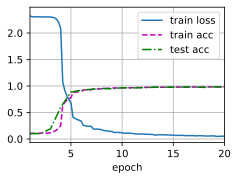

In [123]:
lr, num_epochs = 0.95, 20
y = train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())


In [137]:
# preds = net(test_data).detach().numpy()

torch.save(net, 'model.pth') #保存模型